# Learner corpora Bolo 2025

In [1]:
library(tidyverse)
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## CELI

In [2]:
celi_data <- read_tsv("source/CELI_lemmafreq.txt")

Rows: 202 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): livello_CEFR, lemma
dbl (2): occurrences, percent

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df_unique <- celi_data %>%
  group_by(lemma) %>%
  summarise(groups = paste(unique(livello_CEFR), collapse = ", "))

write_tsv(df_unique, "celi_unique.txt")

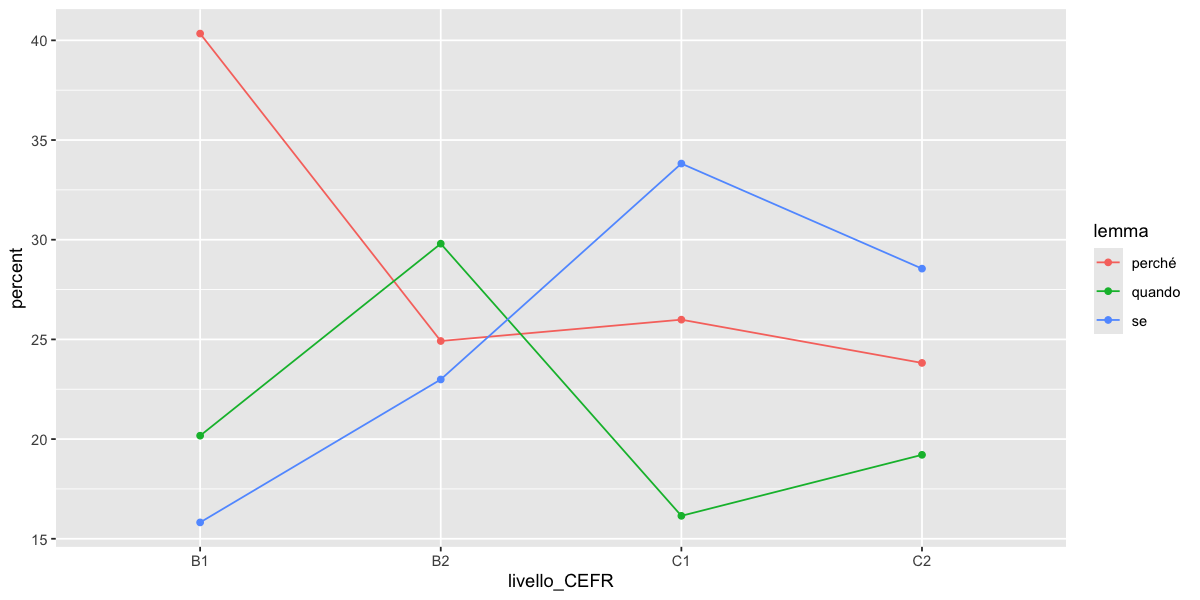

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)

data_lower <- celi_data %>%
  mutate(lemma = tolower(lemma))

data_lower %>%
  filter(lemma %in% c("se", "quando", "perché")) %>%
  ggplot(aes(x = livello_CEFR, y = percent, group = lemma, color = lemma)) +
  geom_line() +
  geom_point()

## KOLIPSI-2

In [5]:
kol_tokfreq <- read_tsv("source/KOLIPSI_tokfreq.txt")
kol_conjfreq <- read_tsv("source/KOLIPSI_SCONJfreq.txt")
kol_lemmafreq <- read_tsv("source/KOLIPSI_lemmafreq.txt")

Rows: 7 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): author_proficiency_level
dbl (1): count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 7 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pos_ud, author_proficiency_level
dbl (1): count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 103 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): pos_ud, lemma, author_proficiency_level
dbl (1): count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
kol_joined <- left_join(kol_conjfreq, kol_tokfreq, by = "author_proficiency_level")

glimpse(kol_joined)

Rows: 7
Columns: 4
$ pos_ud                   <chr> "SCONJ", "SCONJ", "SCONJ", "SCONJ", "SCONJ", …
$ author_proficiency_level <chr> "B1", "A2", "B2", "unknown", "C1", "C2", "A1"
$ count.x                  <dbl> 5005, 2612, 2387, 471, 457, 153, 26
$ count.y                  <dbl> 178674, 88915, 86150, 18456, 19937, 6693, 929


In [7]:
kol_joined <- kol_joined %>%
  mutate(freq_mil = count.x / count.y * 1000000)

print(kol_joined)

# A tibble: 7 × 5
  pos_ud author_proficiency_level count.x count.y freq_mil
  <chr>  <chr>                      <dbl>   <dbl>    <dbl>
1 SCONJ  B1                          5005  178674   28012.
2 SCONJ  A2                          2612   88915   29376.
3 SCONJ  B2                          2387   86150   27707.
4 SCONJ  unknown                      471   18456   25520.
5 SCONJ  C1                           457   19937   22922.
6 SCONJ  C2                           153    6693   22860.
7 SCONJ  A1                            26     929   27987.


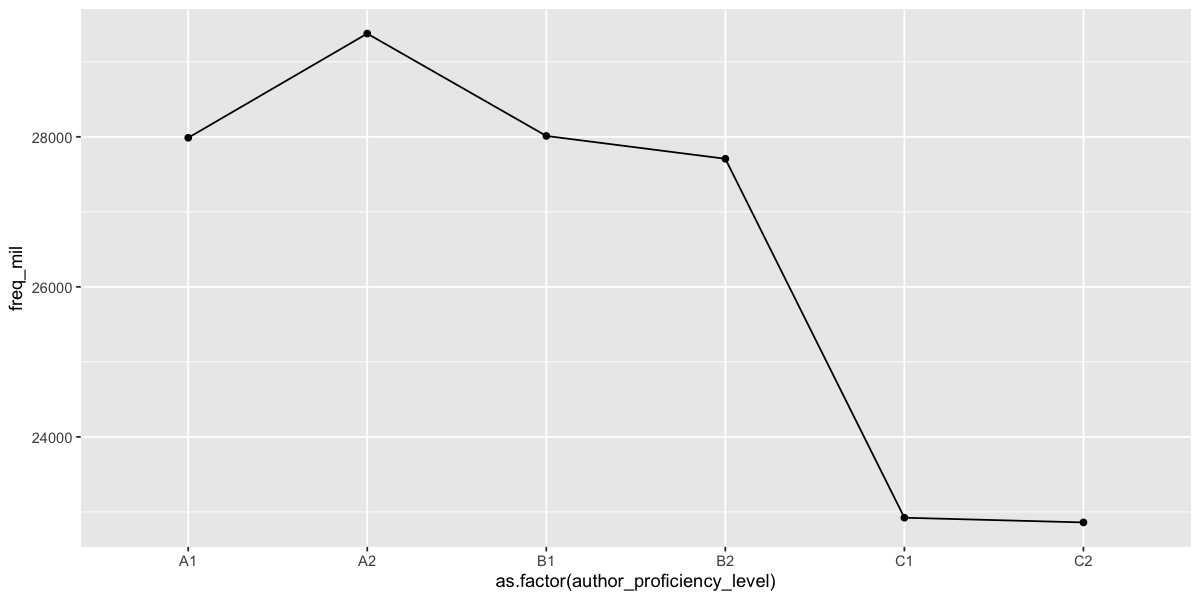

In [9]:
kol_joined %>%
  filter(!author_proficiency_level %in% "unknown") %>%
  ggplot(aes(x = as.factor(author_proficiency_level), y = freq_mil, group = 1)) +
    geom_line() +
    geom_point()

In [10]:
kol_lemma_joined <- left_join(kol_lemmafreq, kol_conjfreq, by = "author_proficiency_level") %>%
  filter(!author_proficiency_level %in% "unknown")

glimpse(kol_lemma_joined)

Rows: 90
Columns: 6
$ pos_ud.x                 <chr> "SCONJ", "SCONJ", "SCONJ", "SCONJ", "SCONJ", …
$ lemma                    <chr> "che", "che", "che", "perché", "se", "perché"…
$ author_proficiency_level <chr> "B1", "A2", "B2", "B1", "B1", "A2", "B1", "B2…
$ count.x                  <dbl> 2482, 1291, 1147, 995, 763, 597, 496, 460, 39…
$ pos_ud.y                 <chr> "SCONJ", "SCONJ", "SCONJ", "SCONJ", "SCONJ", …
$ count.y                  <dbl> 5005, 2612, 2387, 5005, 5005, 2612, 5005, 238…


In [16]:
kol_lemma_cleaned <- kol_lemma_joined %>%
  mutate(lemma = case_when(
    lemma %in% c("perchè", "iperché") ~ "perché",
    TRUE ~ lemma
  )) %>%
  mutate(lemma = tolower(lemma)) %>%
  group_by(author_proficiency_level, lemma, count.y) %>%
  summarise(
    count.x = sum(count.x, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(author_proficiency_level) %>%
  mutate(count.y = count.y - count.x[lemma == "che"]) %>%
  ungroup() %>%
  filter(!lemma %in% "che") %>%
  mutate(percent = count.x / count.y * 100)

unique(kol_lemma_cleaned$lemma)

`summarise()` has grouped output by 'author_proficiency_level', 'lemma'. You
can override using the `.groups` argument.


[1] "perché"    "quando"    "se"        "com'"      "com'é"     "come"     
 [7] "cos'è"     "cosa"      "dopo"      "dove"      "finché"    "mentre"   
[13] "poiché"    "siccome"   "affinché"  "benché"    "comunque"  "dopodiché"
[19] "essere"    "perciò"    "sebbene"   "appena"    "quanto"    "anziché"

In [17]:
kol_types <- kol_lemma_cleaned %>%
  group_by(author_proficiency_level, count.y) %>%
  summarize(types = n_distinct(lemma)) %>%
  ungroup() %>%
  mutate(ttr = types / count.y)

kol_types

`summarise()` has grouped output by 'author_proficiency_level'. You can
override using the `.groups` argument.


author_proficiency_level,count.y,types,ttr
<chr>,<dbl>,<int>,<dbl>
A1,13,3,0.230769231
A2,1321,14,0.010598032
B1,2523,19,0.007530717
B2,1240,19,0.015322581
C1,245,14,0.057142857
C2,83,9,0.108433735


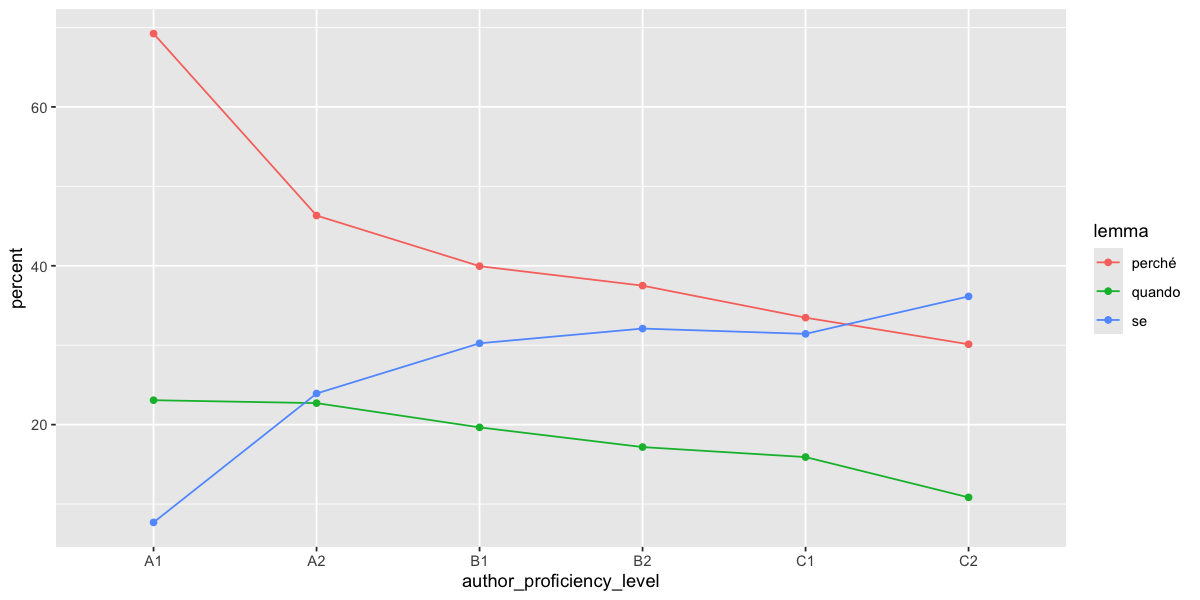

In [18]:
kol_lemma_cleaned %>%
  filter(lemma %in% c("se", "quando", "perché")) %>%
  ggplot(aes(x = author_proficiency_level, y = percent, group = lemma, color = lemma)) +
  geom_line() +
  geom_point()

In [19]:
kol_unique <- kol_lemma_cleaned %>%
  group_by(lemma) %>%
  summarise(groups = paste(unique(author_proficiency_level), collapse = ", "))

write_tsv(kol_unique, "kol_unique.txt")